In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import os
import re
import json
import random
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from pprint import pprint
from IPython.display import Audio
from scipy.io import wavfile

from bark.bark import SAMPLE_RATE, generate_audio, preload_models

In [3]:
def save_history(basepath: str, audio_array: np.ndarray, prompt: str, generation_data: list):
  np.savez(f"{basepath}.npz", semantic_prompt=generation_data[0], coarse_prompt=generation_data[1], fine_prompt=generation_data[2])
  with open(f"{basepath}.txt", "w", encoding="utf-8") as fp: fp.write(prompt)
  wavfile.write(f"{basepath}.wav", SAMPLE_RATE, audio_array)

def load_history(filepath: str):
  return np.load(filepath)

def load_voice(filepath: str):
  sample_rate, audio_array = wavfile.read(filepath)
  return audio_array

In [4]:
NUM_EPOCHS = 1
NUM_STEPS = 10000

BATCH_SIZE = 4

DURATION = 3000

EMBEDDING_DIM = int(DURATION * SAMPLE_RATE / 1000)

In [5]:
class VoiceDataset(Dataset):
  def __init__(self, directory, embedding_dim = EMBEDDING_DIM):
    super().__init__()
    self.k = 1
    self.population = 0
    self.length = 0
    self.embedding_dim = embedding_dim
    self.voices = []
    self.base_map = {}
    for filename in os.listdir(directory):
      if not filename.endswith(".wav"): continue
      self.voices.append([])
      self.population += 1
      folder_name = filename.split(".wav")[0]
      self.base_map[folder_name] = self.population
      for fn in os.listdir(f"./data/bark/{folder_name}"):
        if not fn.endswith(".wav"): continue
        self.voices[-1].append(load_voice(f"./data/bark/{folder_name}/{fn}"))
        self.length += 1

  def __getitem__(self, _):
    samples, targets, labels = [], [], torch.zeros(len(self.voices))
    r_index = random.randint(0, len(self.voices) - 1)
    labels[r_index] = 1
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(s[r:r + self.embedding_dim])
      for t in random.choices(self.voices[r_index], k=self.k):
        r = random.randint(0, len(t) - self.embedding_dim)
        targets.append(t[r:r + self.embedding_dim])
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, -1).float()
    return samples, targets, labels

  def get_selected(self, target):
    samples, targets = [], []
    for person in self.voices:
      for s in random.choices(person, k=self.k):
        r = random.randint(0, len(s) - self.embedding_dim)
        samples.append(s[r:r + self.embedding_dim])
        r = random.randint(0, len(target) - self.embedding_dim)
        targets.append(target[r:r + self.embedding_dim])
    samples = torch.tensor(np.concatenate(samples)).view(len(self.voices) * self.k, -1).float()
    targets = torch.tensor(np.concatenate(targets)).view(len(self.voices) * self.k, -1).float()
    return samples, targets

  def __len__(self): return self.length

In [6]:
dataset = VoiceDataset("./data/bark2")
torch.save(dataset, "./checkpoints/bark_dataset.pt")

In [7]:
dataset = torch.load("./checkpoints/bark_dataset.pt")
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE)

In [8]:
class Judge(nn.Module):
  def __init__(self, k):
    super().__init__()
    self.k = k
    self.seq1 = nn.Sequential(
      nn.Conv1d(1, 64, int(0.025 * SAMPLE_RATE), int(0.01 * SAMPLE_RATE)),
      nn.BatchNorm1d(64),
      nn.MaxPool1d(4),
      nn.ReLU(True),
      nn.Conv1d(64, 128, 4),
      nn.BatchNorm1d(128),
      nn.MaxPool1d(2),
      nn.ReLU(True),
      nn.Conv1d(128, 256, 4),
      nn.BatchNorm1d(256),
      nn.MaxPool1d(2),
      nn.ReLU(True)
    )
    self.gru = nn.LSTM(256, 256, 1, batch_first=True, bidirectional=True)
    self.seq2 = nn.Sequential(
      nn.ReLU(),
      nn.Flatten(),
      nn.Dropout(0.3)
    )
    self.seq3 = nn.Sequential(
      nn.Linear(256 * 64, 1024),
      nn.ReLU(True),
      nn.Dropout(0.2),
      nn.Linear(1024, 256),
      nn.ReLU(True),
      nn.Dropout(0.1),
      nn.Linear(256, 64),
      nn.ReLU(True),
      nn.Linear(64, 1),
      nn.Sigmoid(),
    )

  def forward(self, sample, target):
    outputs1 = self.seq1(sample.view(-1, 1, sample.size(1)))
    outputs2 = self.seq1(target.view(-1, 1, target.size(1)))
    outputs1, _ = self.gru(outputs1.permute(0, 2, 1))
    outputs2, _ = self.gru(outputs2.permute(0, 2, 1))
    outputs1 = self.seq2(outputs1)
    outputs2 = self.seq2(outputs2)
    outputs = self.seq3(torch.cat((outputs1, outputs2), dim=1))
    outputs = torch.cat([outputs[i:i + self.k, :] for i in range(0, outputs.size(0), self.k)], dim=1).sum(0)
    return outputs

class Model(nn.Module):
  def __init__(self, k = 1):
    super().__init__()
    self.k = k
    self.judge = Judge(self.k)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, samples, targets):
    outputs = []
    for s, t in zip(samples, targets): outputs.append(self.judge(s, t).unsqueeze(1))
    outputs = torch.cat(tuple(outputs), dim=1).permute(1, 0)
    outputs = self.softmax(outputs)
    return outputs

In [9]:
samples, targets, labels = next(iter(dataloader))
model = Model(dataset.k)
loss_fn = nn.CrossEntropyLoss()
outputs = model(samples, targets)
print(samples.shape, targets.shape)
print(outputs)
print(labels)
print(loss_fn(outputs, labels))

torch.Size([4, 6, 72000]) torch.Size([4, 6, 72000])
tensor([[0.1668, 0.1666, 0.1663, 0.1666, 0.1669, 0.1668],
        [0.1665, 0.1667, 0.1667, 0.1667, 0.1667, 0.1668],
        [0.1668, 0.1666, 0.1663, 0.1666, 0.1670, 0.1666],
        [0.1667, 0.1667, 0.1666, 0.1669, 0.1666, 0.1666]],
       grad_fn=<SoftmaxBackward0>)
tensor([[0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]])
tensor(1.7918, grad_fn=<DivBackward1>)


In [10]:
torch.backends.cudnn.benchmark = True
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Model(dataset.k)
optimizer = optim.Adam(model.parameters(), lr=3e-5)
loss_fn = nn.CrossEntropyLoss()
losses = []

model.train()

if device == "cuda": model.cuda()
for step in range(1, NUM_STEPS + 1):
  optimizer.zero_grad()
  samples, targets, labels = next(iter(dataloader))
  outputs = model(samples.to(device), targets.to(device))
  loss = loss_fn(outputs.to(device), labels.to(device))
  losses.append(loss.item())
  loss.backward()
  optimizer.step()
  if step % 100 == 0:
    print(f"{step}/{NUM_STEPS}:\t{np.mean(losses):.4f}")
    losses = []
print("Training Ended!")

100/10000:	1.7918
200/10000:	1.7918
300/10000:	1.7918
400/10000:	1.7917
500/10000:	1.7918
600/10000:	1.7917
700/10000:	1.7919
800/10000:	1.7916
900/10000:	1.7918
1000/10000:	1.7918
1100/10000:	1.7918
1200/10000:	1.7915
1300/10000:	1.7915
1400/10000:	1.7913
1500/10000:	1.7899
1600/10000:	1.7683
1700/10000:	1.7380
1800/10000:	1.7303
1900/10000:	1.7294
2000/10000:	1.7314
2100/10000:	1.7270
2200/10000:	1.7270
2300/10000:	1.7291
2400/10000:	1.7293
2500/10000:	1.7299
2600/10000:	1.7263
2700/10000:	1.7237
2800/10000:	1.7377
2900/10000:	1.7308
3000/10000:	1.7266
3100/10000:	1.7255
3200/10000:	1.7254
3300/10000:	1.7318
3400/10000:	1.7242
3500/10000:	1.7248
3600/10000:	1.7235
3700/10000:	1.7270
3800/10000:	1.7232
3900/10000:	1.7222
4000/10000:	1.7220
4100/10000:	1.7209
4200/10000:	1.7125
4300/10000:	1.7152
4400/10000:	1.7091
4500/10000:	1.7111
4600/10000:	1.7040
4700/10000:	1.7030
4800/10000:	1.7031
4900/10000:	1.7036
5000/10000:	1.6966
5100/10000:	1.6975
5200/10000:	1.6965
5300/10000:	1.6931
54

In [ ]:
with torch.no_grad():
  t = load_voice("./data/bark/man-2.wav")
  samples, targets = dataset.get_selected(t)
  outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
  print(np.round(outputs.cpu().numpy(), 3))
  print(outputs.cpu().numpy().argmax() + 1)
  pprint(dataset.base_map)
  display(Audio(samples[0], rate=SAMPLE_RATE))
  display(Audio(targets[0], rate=SAMPLE_RATE))
  display(Audio(samples[1], rate=SAMPLE_RATE))
  display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

6


100%|██████████| 1000/1000 [00:09<00:00, 100.73it/s]


array([[0.31235581, 0.12412785, 0.18997531, 0.12266066, 0.12806546,
        0.12281492]])

array([841.,   3., 150.,   0.,   6.,   0.])

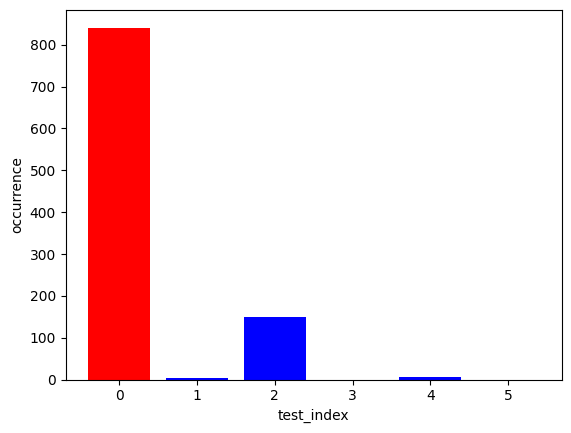

100%|██████████| 1000/1000 [00:09<00:00, 101.53it/s]


array([[0.12154142, 0.32462451, 0.18956741, 0.12142222, 0.12142222,
        0.12142222]])

array([  0., 943.,  57.,   0.,   0.,   0.])

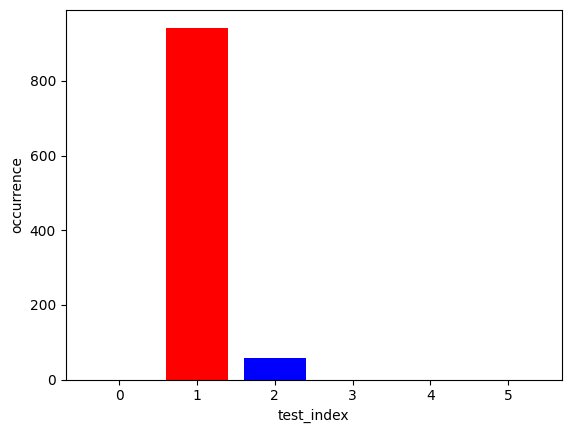

100%|██████████| 1000/1000 [00:10<00:00, 99.34it/s]


array([[0.18352684, 0.1575855 , 0.3051818 , 0.11787448, 0.11795687,
        0.11787451]])

array([108.,  74., 817.,   0.,   1.,   0.])

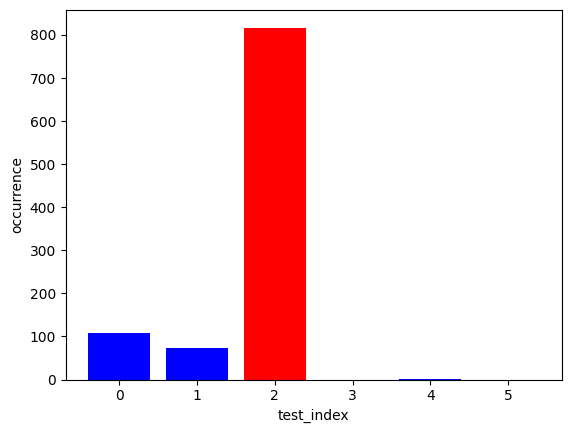

100%|██████████| 1000/1000 [00:09<00:00, 103.94it/s]


array([[0.12912187, 0.12806505, 0.12806505, 0.31232434, 0.13447433,
        0.16794935]])

array([  2.,   0.,   0., 855.,  20., 123.])

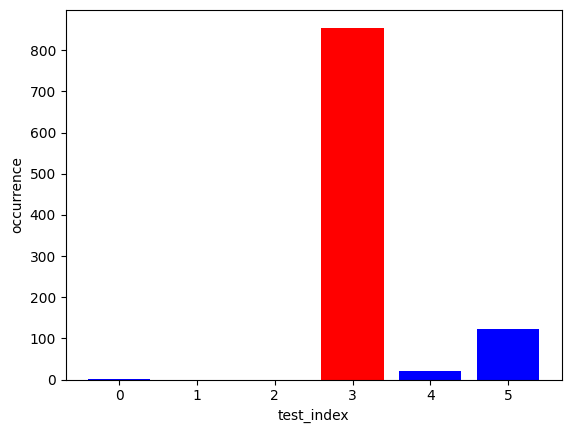

100%|██████████| 1000/1000 [00:09<00:00, 100.91it/s]


array([[0.16093375, 0.11084652, 0.11269597, 0.11659742, 0.29098434,
        0.207942  ]])

array([ 62.,   0.,   2.,  15., 794., 127.])

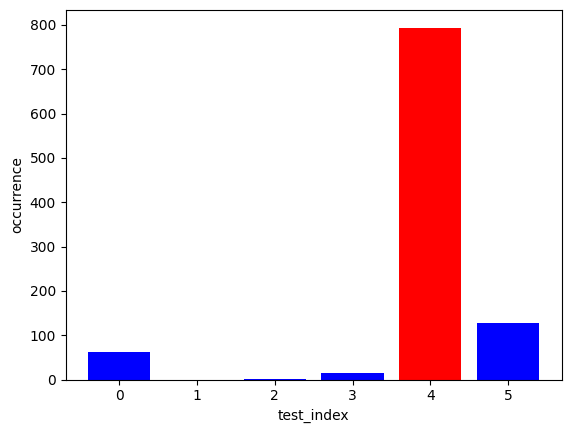

100%|██████████| 1000/1000 [00:10<00:00, 95.84it/s]


array([[0.12202514, 0.12057111, 0.12112552, 0.15492145, 0.17471067,
        0.30664612]])

array([  5.,   0.,   1.,  56.,  77., 861.])

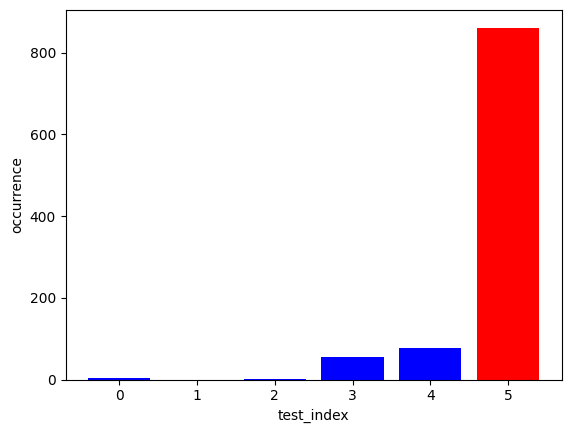

In [11]:
num_validation = 1000
#test_cases = ["man-1", "man-2", "man-3", "man-4", "man-5", "woman-1", "woman-2", "woman-3", "woman-4", "woman-5"]
test_cases = ["man-1", "man-2", "man-3", "woman-1", "woman-2", "woman-3"]
from tqdm import tqdm
print(len(dataset.voices))
with torch.no_grad():
  for test_index in range(len(dataset.voices)):
    colors = ["b" if i != test_index else "r" for i in range(len(dataset.voices))]
    avg = np.zeros((1, len(dataset.voices)))
    occurrences = np.zeros(len(dataset.voices))
    for i in tqdm(range(num_validation)):
      t = load_voice(f"./data/bark/{test_cases[test_index]}.wav")
      samples, targets = dataset.get_selected(t)
      outputs = model(samples.to(device).unsqueeze(0), targets.to(device).unsqueeze(0))
      avg += outputs.cpu().numpy()
      occurrences[outputs.cpu().numpy().argmax()] += 1
    display(avg / num_validation)
    display(occurrences)
    plt.bar(np.arange(len(dataset.voices)), occurrences, color=colors)
    plt.xticks(range(len(dataset.voices)))
    plt.xlabel("test_index")
    plt.ylabel("occurrence")
    plt.show()
  # display(Audio(samples[0], rate=SAMPLE_RATE))
  # display(Audio(targets[0], rate=SAMPLE_RATE))
  # display(Audio(samples[1], rate=SAMPLE_RATE))
  # display(Audio(targets[1], rate=SAMPLE_RATE))
  # display(Audio(samples[2], rate=SAMPLE_RATE))
  # display(Audio(targets[2], rate=SAMPLE_RATE))

In [ ]:
torch.save(model,"./checkpoints/model.pt")

In [ ]:
preload_models(use_smaller_models=True)

In [ ]:
def generate(basename, raw_prompt, index):
  basepath = "./data/bark/"
  text_prompt = re.sub(r"\s\s+", " ", re.sub(r"[\t\n]", "", raw_prompt)).strip()
  print(f"{basename}: prompt-{index}")
  audio_array, generation_data = generate_audio(text_prompt, basename)
  if basename not in os.listdir(basepath): os.mkdir(f"{basepath}/{basename}")
  save_history(f"{basepath}/{basename}/prompt-{index}", audio_array, text_prompt, generation_data)

In [ ]:
with open("./prompts.json") as fp: raw_prompts = json.load(fp)
len(raw_prompts)

In [ ]:
prompt = "Bark was developed for research purposes. It is not a conventional text-to-speech model but instead a fully generative text-to-audio model, which can deviate in unexpected ways from provided prompts."
audio_array, generation_data = generate_audio(prompt)
Audio(audio_array, rate=SAMPLE_RATE)

In [ ]:
save_history("./data/bark/woman-4", audio_array, prompt, generation_data)